# 城市路网分析与可达性评估 

In [7]:
# 环境初始化：导入所有必需的库
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import MultiPoint
import warnings
import contextily as ctx
import xyzservices.providers as xyz
warnings.filterwarnings('ignore')  # 忽略无关警告，保持输出整洁

# 设置中文字体支持（解决matplotlib中文显示问题）
plt.rcParams["font.family"] = ["Times New Roman", "SimSun"]  # 英文字体为新罗马，中文字体为宋体
plt.rcParams["font.serif"] = ["Times New Roman", "SimSun"]  # 衬线字体
plt.rcParams["font.sans-serif"] = ["Times New Roman", "SimSun", "Arial", "SimHei"]  # 无衬线字体，与Latex相关
plt.rcParams["mathtext.fontset"] = "custom"

plt.rcParams['axes.unicode_minus'] = False
print("环境初始化完成，所有库已成功导入！")

环境初始化完成，所有库已成功导入！


## 一、路网数据下载与可视化（以纽约曼哈顿为例）
### 1.1 核心原理
- **OpenStreetMap（OSM）**：全球开放地理数据库，包含道路、建筑等丰富信息
- **OSMnx库**：封装OSM API调用，支持一行代码下载路网并转换为NetworkX图对象
- **图模型结构**：
  - 节点（Nodes）：代表交叉路口或道路端点，包含经纬度坐标
  - 边（Edges）：代表街道段，包含长度、名称、类型（如residential/highway）、单行道等属性

### 1.2 代码实现

In [8]:

# 1. 定义研究区域（可替换为任意城市/区域，如"Beijing, China"）
place_name = "Manhattan, New York City"
print(f"正在从OpenStreetMap下载 '{place_name}' 的驾驶路网数据...")

# 2. 下载驾驶路网（network_type可选：drive/walk/bike/all）
G = ox.graph_from_place(place_name, network_type='drive')
print(f"路网下载完成！图结构统计：")
print(f"- 节点数量：{G.number_of_nodes()}")
print(f"- 边数量：{G.number_of_edges()}")

# 3. 投影转换（将经纬度坐标系转为UTM坐标系，使长度单位为"米"）
G_proj = ox.project_graph(G)


正在从OpenStreetMap下载 'Manhattan, New York City' 的驾驶路网数据...
路网下载完成！图结构统计：
- 节点数量：4619
- 边数量：9900


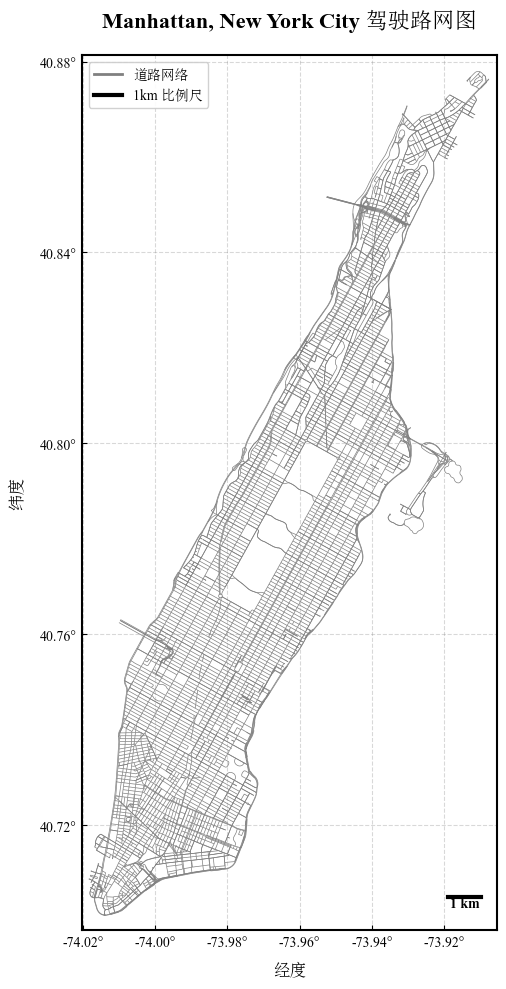

路网图已保存为 Manhattan, New York City_路网图_改进版.png
路网数据已保存为 manhattan_drive_network.graphml


<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle

# 4. 可视化路网（改进版）
fig, ax = plt.subplots(figsize=(12, 10))

# 绘制路网
ox.plot_graph(
    G,
    ax=ax,
    bgcolor="#FFFFFF",        # 背景色：白色
    edge_color="gray",       # 道路颜色：灰色
    node_size=0,             # 隐藏节点（避免画面杂乱）
    edge_linewidth=0.5,      # 道路线宽
    show=False,              # 不自动显示（后续统一控制）
    close=False,             # 不自动关闭画布
)

# 获取图形的边界框
nodes, edges = ox.graph_to_gdfs(G)
bounds = nodes.total_bounds
xmin, ymin, xmax, ymax = bounds

# 设置坐标轴范围为矩形，并稍微扩展边界
margin_x = (xmax - xmin) * 0.02
margin_y = (ymax - ymin) * 0.02
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

# 设置坐标轴样式 - 黑色实线边框
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# 设置网格
ax.grid(True, linestyle='--', alpha=0.3, color='gray')

# 设置坐标轴刻度和标签格式
def format_degree_ticks(value, pos):
    """将十进制度数转换为度分秒格式"""
    # degrees = int(value)
    # minutes = int((value - degrees) * 60)
    # seconds = (value - degrees - minutes/60) * 3600
    return f"{value:.2f}°"

# 应用度格式
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_degree_ticks))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_degree_ticks))

# 设置刻度密度
ax.xaxis.set_major_locator(mticker.MaxNLocator(6))
ax.yaxis.set_major_locator(mticker.MaxNLocator(6))

# 设置坐标轴标签
ax.set_xlabel('经度', fontsize=12, labelpad=10)
ax.set_ylabel('纬度', fontsize=12, labelpad=10)

ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
# 添加标题
ax.set_title(f'{place_name} 驾驶路网图', fontsize=16, pad=20, fontweight='bold')

# 添加比例尺
def add_scale_bar(ax, length_km=1, location='lower right'):
    """添加比例尺"""
    # 将公里转换为度（近似，在赤道附近1度≈111km）
    length_deg = length_km / 111
    
    if location == 'lower right':
        x = xmax - margin_x - length_deg
        y = ymin + margin_y
    else:  # lower left
        x = xmin + margin_x
        y = ymin + margin_y
    
    # 绘制比例尺
    ax.plot([x, x + length_deg], [y, y], color='black', linewidth=3)
    ax.plot([x, x], [y - length_deg*0.01, y + length_deg*0.01], color='black', linewidth=2)
    ax.plot([x + length_deg, x + length_deg], [y - length_deg*0.01, y + length_deg*0.01], 
            color='black', linewidth=2)
    
    # 添加标签
    ax.text(x + length_deg/2, y - length_deg*0.02, f'{length_km} km', 
            ha='center', va='top', fontsize=10, fontweight='bold')

# 添加比例尺
add_scale_bar(ax, length_km=1, location='lower right')


# 添加图例说明
legend_elements = [
    plt.Line2D([0], [0], color='gray', lw=2, label='道路网络'),
    plt.Line2D([0], [0], color='black', lw=3, label='1km 比例尺')
]

ax.legend(handles=legend_elements, loc='upper left', framealpha=0.9)

plt.tight_layout()
plt.show()

# 保存改进后的图形
plt.savefig(f'{place_name}_路网图_改进版.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='black')
print(f"路网图已保存为 {place_name}_路网图_改进版.png")

# 保存原始图数据（供后续分析使用）
ox.save_graphml(G, "manhattan_drive_network.graphml")
print("路网数据已保存为 manhattan_drive_network.graphml")

## 二、最短路径分析（帝国大厦→时代广场）
### 2.1 核心原理
1. **地理编码**：通过`ox.geocode()`将地址字符串转为经纬度坐标
2. **节点吸附**：通过`ox.nearest_nodes()`将真实地址坐标匹配到路网节点（解决"地址不在节点上"问题）
3. **最短路径算法**：使用NetworkX的`nx.shortest_path()`，基于道路长度（`weight='length'`）计算物理距离最短路径

### 2.2 代码实现

In [10]:
# 1. 定义起止点地址（可替换为任意地址）
origin_address = "Empire State Building, New York, NY"  # 起点：帝国大厦
dest_address = "Times Square, New York, NY"              # 终点：时代广场

# 2. 地理编码：地址→经纬度
origin_point = ox.geocode(origin_address)  # (纬度, 经度)
dest_point = ox.geocode(dest_address)
print(f"起点坐标（{origin_address}）：{origin_point}")
print(f"终点坐标（{dest_address}）：{dest_point}")

# 3. 节点吸附：经纬度→路网节点ID
# 注意：G_proj的节点属性中，x=经度，y=纬度，需对应传入
origin_node = ox.nearest_nodes(G, origin_point[1], origin_point[0])
dest_node = ox.nearest_nodes(G, dest_point[1], dest_point[0])
print(f"起点匹配节点ID：{origin_node}")
print(f"终点匹配节点ID：{dest_node}")

# 4. 计算最短路径（基于道路长度）
shortest_path = nx.shortest_path(G_proj, origin_node, dest_node, weight='length')
print(f"最短路径包含 {len(shortest_path)} 个节点")

# 5. 计算路径总长度（单位：米→千米）
path_length = nx.shortest_path_length(G_proj, origin_node, dest_node, weight='length') / 1000
print(f"最短路径总长度：{path_length:.2f} 千米")



起点坐标（Empire State Building, New York, NY）：(40.7484421, -73.9856589)
终点坐标（Times Square, New York, NY）：(40.7572614, -73.9858998)
起点匹配节点ID：42446701
终点匹配节点ID：42439984
最短路径包含 16 个节点
最短路径总长度：1.63 千米


起点坐标（Empire State Building, New York, NY）：(40.7484421, -73.9856589)
终点坐标（Times Square, New York, NY）：(40.7572614, -73.9858998)
起点匹配节点ID：42446701
终点匹配节点ID：42439984
最短路径包含 16 个节点
最短路径总长度：1.63 千米


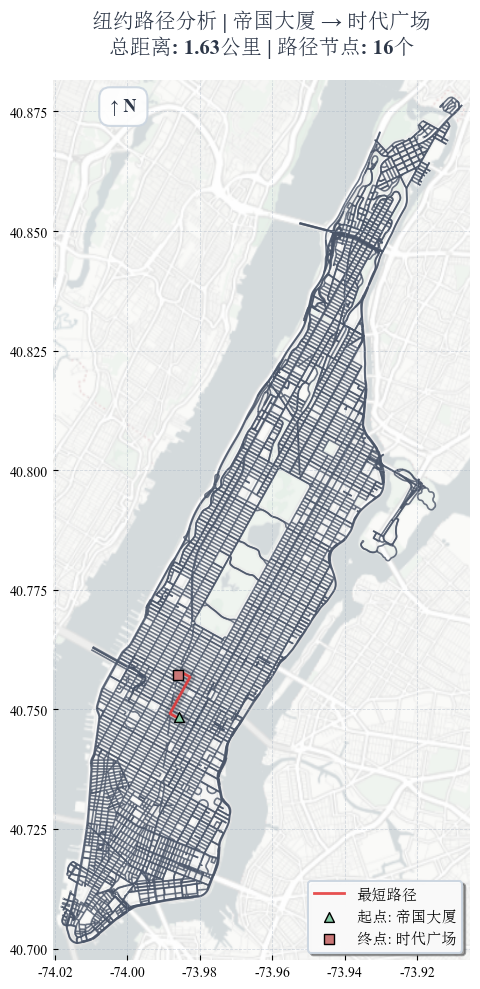

最短路径数据已保存为 shortest_path_nodes.txt


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

# 设置美化参数
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 1. 定义起止点地址（可替换为任意地址）
origin_address = "Empire State Building, New York, NY"  # 起点：帝国大厦
dest_address = "Times Square, New York, NY"              # 终点：时代广场

# 2. 地理编码：地址→经纬度
origin_point = ox.geocode(origin_address)  # (纬度, 经度)
dest_point = ox.geocode(dest_address)
print(f"起点坐标（{origin_address}）：{origin_point}")
print(f"终点坐标（{dest_address}）：{dest_point}")

# 3. 节点吸附：经纬度→路网节点ID
origin_node = ox.nearest_nodes(G, origin_point[1], origin_point[0])
dest_node = ox.nearest_nodes(G, dest_point[1], dest_point[0])
print(f"起点匹配节点ID：{origin_node}")
print(f"终点匹配节点ID：{dest_node}")

# 4. 计算最短路径（基于道路长度）
shortest_path = nx.shortest_path(G_proj, origin_node, dest_node, weight='length')
print(f"最短路径包含 {len(shortest_path)} 个节点")

# 5. 计算路径总长度（单位：米→千米）
path_length = nx.shortest_path_length(G_proj, origin_node, dest_node, weight='length') / 1000
print(f"最短路径总长度：{path_length:.2f} 千米")

# 6. 改进的可视化部分
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# 绘制基础路网
ox.plot_graph(
    G,
    ax=ax,
    edge_color='#4A5568',      # 深灰色道路
    edge_linewidth=1.2,
    edge_alpha=0.8,
    node_size=0,
    bgcolor='#F7FAFC',         # 浅蓝色背景
    show=False,
    close=False
)

# 高亮显示最短路径
route_nodes = shortest_path
route_lons = [G.nodes[node]['x'] for node in route_nodes]
route_lats = [G.nodes[node]['y'] for node in route_nodes]

# 添加路径阴影效果
ax.plot(route_lons, route_lats, color='#2D3748', linewidth=8, 
        alpha=0.3, zorder=3)

# 主路径
ax.plot(route_lons, route_lats, color='#E53E3E', linewidth=2, 
        alpha=0.9, label='最短路径', zorder=4)

# 美化起止点标记
# 起点标记
ax.scatter(origin_point[1], origin_point[0], 
           c="#84C9A4", s=50, marker='^', edgecolors='black', 
           linewidth=1, label='起点: 帝国大厦', zorder=5)

# 终点标记
ax.scatter(dest_point[1], dest_point[0], 
           c="#CA7777", s=50, marker='s', edgecolors='black', 
           linewidth=1, label='终点: 时代广场', zorder=5)


# 设置标题
ax.set_title(f'纽约路径分析 | 帝国大厦 → 时代广场\n总距离: {path_length:.2f}公里 | 路径节点: {len(shortest_path)}个', 
            fontsize=15, fontweight='bold', pad=20, color='#2D3748')

# 创建美观的图例
legend = ax.legend(loc='lower right', fontsize=11, 
                  framealpha=0.95, edgecolor='#CBD5E0', 
                  facecolor='white', shadow=True)
legend.get_frame().set_linewidth(1.5)

# 添加经纬度网格
ax.grid(True, alpha=0.4, linestyle='--', color='#A0AEC0', linewidth=0.6)
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)


# 添加指北针
ax.text(0.20, 0.98, '↑ N', transform=ax.transAxes, fontsize=13, fontweight='bold',
       bbox=dict(boxstyle="round,pad=0.6", facecolor='white', alpha=0.9, 
                edgecolor='#CBD5E0', linewidth=1.5),
       verticalalignment='top', horizontalalignment='right',
       color='#2D3748', zorder=10)
ctx.add_basemap(
    ax=ax,# 关键
    crs=G.graph['crs'],
    source='https://d.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'
)

plt.tight_layout()
plt.show()

# 保存路径数据
with open("shortest_path_nodes.txt", "w") as f:
    f.write(f"起止点：{origin_address} → {dest_address}\n")
    f.write(f"总长度：{path_length:.2f}km\n")
    f.write(f"路径节点ID列表：{shortest_path}")
print("最短路径数据已保存为 shortest_path_nodes.txt")


## 三、服务区（等时圈）与可达性分析（以纽约大学为中心）
### 3.1 核心原理
1. **步行网络构建**：下载步行路网并添加`travel_time`属性（基于默认步行速度：5km/h）
2. **等时圈生成**：通过`nx.ego_graph()`以"旅行时间"为半径，筛选可达节点，再通过`convex_hull`生成最小包围多边形
3. **POI空间查询**：通过OSM标签（如`{"amenity": "hospital"}`）下载兴趣点，再通过`gpd.sjoin()`筛选等时圈内的POI
4. **交互式可视化**：使用Folium生成HTML地图，支持缩放、点击查看POI信息

### 3.2 代码实现
#### 3.2.1 步行路网与等时圈生成

In [ ]:
# 1. 下载步行路网（network_type='walk'）
print("正在下载曼哈顿步行路网...")
G_walk = ox.graph_from_place(place_name, network_type='walk')

# 2. 添加边属性：速度（默认）与旅行时间（单位：秒）
G_walk = ox.add_edge_speeds(G_walk)  # 步行默认速度：5 km/h
G_walk = ox.add_edge_travel_times(G_walk)  # 旅行时间 = 长度 / 速度
print("步行路网准备完成！")
print(f"- 步行路网节点数：{G_walk.number_of_nodes()}")
print(f"- 步行路网边数：{G_walk.number_of_edges()}")

# 3. 定义分析参数
center_address = "New York University, New York, NY"  # 中心地址：纽约大学
travel_time_minutes = 15  # 可达时间：15分钟
travel_time_seconds = travel_time_minutes * 60  # 转换为秒

# 4. 中心地址→经纬度→路网节点
center_point = ox.geocode(center_address)
center_node = ox.nearest_nodes(G_walk, center_point[1], center_point[0])
print(f"分析中心：{center_address}（坐标：{center_point}，节点ID：{center_node}）")

# 5. 生成等时圈（15分钟步行可达节点）
# ego_graph：以center_node为中心，travel_time_seconds为半径筛选可达节点
subgraph = nx.ego_graph(
    G_walk,
    center_node,
    radius=travel_time_seconds,
    distance='travel_time'  # 以旅行时间为"距离"度量
)

# 6. 从可达节点生成等时圈多边形
# 提取节点经纬度
node_points = [
    (data['x'], data['y'])  # (经度, 纬度)
    for node, data in subgraph.nodes(data=True)
    if 'x' in data and 'y' in data  # 确保节点有坐标属性
]

# 生成最小凸多边形（convex_hull）
# 稳健性保证
if len(node_points) >= 3:  # 至少3个点才能构成多边形
    isochrone_polygon = MultiPoint(node_points).convex_hull
    # 转换为GeoDataFrame（便于后续空间分析）
    isochrone_gdf = gpd.GeoDataFrame(
        [{'geometry': isochrone_polygon, 'travel_time_min': travel_time_minutes}],
        crs=G_walk.graph['crs']  # 继承路网坐标系（WGS84）
    )
    print(f"成功生成 {travel_time_minutes} 分钟步行等时圈！")
else:
    raise ValueError("可达节点数量不足，无法生成等时圈，请检查路网数据或调整时间参数")

# # 7. 可视化等时圈（静态图）
# fig, ax = plt.subplots(figsize=(10, 10))
# # 绘制步行路网（浅灰色）
# ox.plot_graph(G_walk, ax=ax, bgcolor="#FFFFFF", edge_color="lightgray", node_size=0, show=False, close=False)
# # 绘制等时圈（蓝色半透明）
# isochrone_gdf.plot(ax=ax, color="blue", alpha=0.3, edgecolor="blue", linewidth=2, label=f'{travel_time_minutes}分钟步行圈')
# # 绘制中心点（红色）
# ax.scatter(center_point[1], center_point[0], c='red', s=150, marker='*', label=f'中心：{center_address}', zorder=5)

# # 添加标题与图例
# ax.set_title(f'{center_address}\n{travel_time_minutes}分钟步行等时圈分析', fontsize=16, pad=20)
# ax.legend(loc='upper right', fontsize=12)
# plt.tight_layout()
# plt.show()

# # 保存等时圈数据
# isochrone_gdf.to_file("isochrone_15min.geojson", driver="GeoJSON")
# print("等时圈数据已保存为 isochrone_15min.geojson")

正在下载曼哈顿步行路网...
步行路网准备完成！
- 步行路网节点数：37409
- 步行路网边数：119926
分析中心：New York University, New York, NY（坐标：(40.7292053, -73.9950148)，节点ID：8309478899）
成功生成 15 分钟步行等时圈！


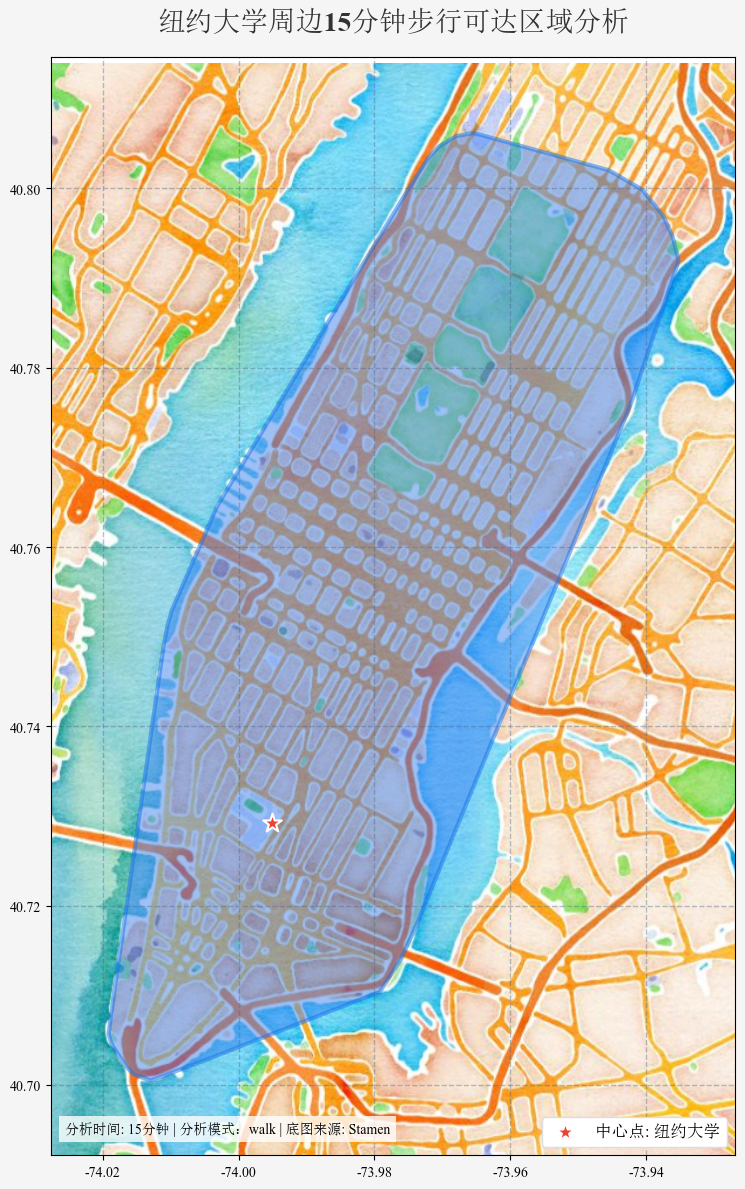

等时圈数据已保存为 isochrone_15min.geojson


In [13]:
# 7. 优化可视化（使用Stamen Watercolor底图）
import contextily as ctx
import xyzservices.providers as xyz
# 创建图形
fig, ax = plt.subplots(figsize=(12, 12), facecolor='#F5F5F5')

# 将等时圈转换为Web墨卡托投影（与底图匹配）
isochrone_web_mercator = isochrone_gdf.to_crs(epsg=3857)

# 绘制等时圈（使用更现代的颜色）
isochrone_gdf.plot(
    ax=ax,
    color="#4285F4",  # Google蓝色
    alpha=0.5,  # 半透明
    edgecolor="#1A73E8",  # 深蓝色边框
    linewidth=3,  # 边框宽度
    label=f'{travel_time_minutes}分钟步行可达区域'
)

# 配置Stamen Watercolor底图（使用您的API key）
api_key = "464fc2cb-f81f-460b-a772-66597280618e"  # 这里填你在 StadiaMaps 获取的 key
stamen_watercolor_url = (
    f"https://tiles.stadiamaps.com/tiles/stamen_watercolor/{{z}}/{{x}}/{{y}}.jpg?api_key={api_key}"
)

# 添加Stamen Watercolor底图
# 添加contextily底图
ctx.add_basemap(
    ax=ax,# 关键
    crs=isochrone_gdf.crs,
    source=stamen_watercolor_url
    # source=ctx.providers.Stadia.StamenWatercolor
)

# 绘制中心点（使用更醒目的标记）
ax.scatter(
    center_point[1],  # 经度
    center_point[0],  # 纬度
    c='#EA4335',  # Google红色
    s=200,  # 标记大小
    marker='*',  # 星形标记
    edgecolor='white',  # 白色边框
    linewidth=1.5,  # 边框宽度
    zorder=10,  # 确保在最上层
    label=f'中心点: 纽约大学'
)

# 设置标题和样式
title = f"纽约大学周边{travel_time_minutes}分钟步行可达区域分析"
ax.set_title(title, fontsize=20, pad=20, fontweight='heavy', color='#333333')

# 设置图例（右下角）
ax.legend(
    loc='lower right',
    framealpha=1,  # 不透明
    facecolor='white',  # 白色背景
    edgecolor='#DDDDDD',  # 浅灰色边框
    fontsize=12
)

# 添加数据说明
ax.text(
    0.02, 0.02,  # 左下角位置
    f"分析时间: {travel_time_minutes}分钟 | 分析模式：walk | 底图来源: Stamen",
    transform=ax.transAxes,  # 使用轴坐标
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')  # 白色半透明背景
)

# 调整坐标轴范围（基于等时圈范围自动扩展10%）
bounds = isochrone_polygon.bounds
margin = (bounds[2] - bounds[0]) * 0.1  # 10%边距
ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
ax.set_ylim(bounds[1] - margin, bounds[3] + margin)

# 添加经纬度网格
ax.grid(True, alpha=0.4, linestyle='--', color="#4B668A", linewidth=1.0)
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)

plt.tight_layout()
plt.show()

# 保存等时圈数据（保持不变）
isochrone_gdf.to_file("isochrone_15min.geojson", driver="GeoJSON")
print("等时圈数据已保存为 isochrone_15min.geojson")

#### 3.2.2 POI（医院）可达性分析与交互式地图

In [16]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import geopandas as gpd
import osmnx as ox
from branca.colormap import linear

# ----------------------补充缺失的关键参数定义----------------------
# 根据需求修改这些参数，确保与GPKG数据的纽约区域匹配
center_address = "Manhattan, New York"
center_point = (40.7128, -74.0060)  # 纽约曼哈顿中心点经纬度
travel_time_minutes = 15

# 这里用中心点创建一个简单的圆形等时圈作为示例
from shapely.geometry import Point
import matplotlib.pyplot as plt

# ----------------------原有POI分析代码----------------------
# 定义三种POI类别及其OSM标签
poi_categories = {
    "医院": {"amenity": "hospital"},
    "学校": {"amenity": ["school", "university", "college"]},
    "公园": {"leisure": "park"}
}

# 1. 下载研究区域内的三种POI数据
poi_data = {}
print(f"正在下载 {place_name} 区域内的POI数据...")

for category, tags in poi_categories.items():
    print(f"正在下载{category}数据...")
    pois = ox.features_from_place(place_name, tags)
    # 只保留点类型POI
    pois = pois[pois.geometry.geom_type == 'Point'].copy()
    poi_data[category] = pois.to_crs(isochrone_gdf.crs)  # 统一坐标系
    print(f"  - 找到 {len(pois)} 个{category}")

# 2. 空间连接：筛选等时圈内的POI
poi_stats = {}
filtered_poi_data = {}

for category, pois in poi_data.items():
    pois_in = gpd.sjoin(pois, isochrone_gdf, predicate='within', how='inner')
    pois_out = pois[~pois.index.isin(pois_in.index)]
    
    poi_stats[category] = {
        'total': len(pois),
        'inside': len(pois_in),
        'outside': len(pois_out),
        'percentage': len(pois_in)/len(pois)*100 if len(pois) > 0 else 0
    }
    
    filtered_poi_data[f"{category}_in"] = pois_in
    filtered_poi_data[f"{category}_out"] = pois_out

# 3. 打印统计结果
print(f"\n=== {center_address} {travel_time_minutes}分钟步行可达性分析 ===")
print(f"研究区域：{place_name}")
print(f"分析中心：{center_address}")
print(f"可达时间：{travel_time_minutes}分钟（步行）")
print(f"分析时间：{pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

for category, stats in poi_stats.items():
    print(f"{category}可达性分析：")
    print(f"  - 总数：{stats['total']} 个")
    print(f"  - 可达数量：{stats['inside']} 个")
    print(f"  - 不可达数量：{stats['outside']} 个")
    print(f"  - 可达率：{stats['percentage']:.1f}%")
    print()

# 4. 生成基础交互式地图
m = folium.Map(
    location=center_point,
    zoom_start=12,  # 纽约区域适合放大到12级
    tiles="Cartodb positron"
)

# 4.1 添加等时圈
folium.GeoJson(
    isochrone_gdf,
    name=f'{travel_time_minutes}分钟步行圈',
    style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'blue',
        'weight': 2,
        'fillOpacity': 0.2
    },
    tooltip=f'{travel_time_minutes}分钟步行可达区域'
).add_to(m)

# 4.2 为每种POI类别创建图层组
layer_groups = {}
poi_styles = {
    "医院": {"color": "green", "icon": "hospital", "prefix": "fa"},
    "学校": {"color": "orange", "icon": "graduation-cap", "prefix": "fa"},
    "公园": {"color": "darkgreen", "icon": "tree", "prefix": "fa"}
}

# 创建图层组并添加POI标记
for category in poi_categories.keys():
    layer_group_in = folium.FeatureGroup(name=f"{category}（可达）", show=False)
    layer_group_out = folium.FeatureGroup(name=f"{category}（不可达）", show=False)
    style = poi_styles[category]

    # 添加可达POI
    pois_in = filtered_poi_data[f"{category}_in"]
    for idx, row in pois_in.iterrows():
        name = row.get('name', f'未命名{category}')
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=f"<b>{category}名称</b>：{name}<br><b>状态</b>：{travel_time_minutes}分钟内可达",
            icon=folium.Icon(color=style["color"], icon=style["icon"], prefix=style["prefix"]),
            tooltip=name
        ).add_to(layer_group_in)

    # 添加不可达POI
    pois_out = filtered_poi_data[f"{category}_out"]
    for idx, row in pois_out.iterrows():
        name = row.get('name', f'未命名{category}')
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=f"<b>{category}名称</b>：{name}<br><b>状态</b>：{travel_time_minutes}分钟外",
            icon=folium.Icon(color="red", icon=style["icon"], prefix=style["prefix"]),
            tooltip=name
        ).add_to(layer_group_out)

    layer_group_in.add_to(m)
    layer_group_out.add_to(m)
    layer_groups[category] = {"in": layer_group_in, "out": layer_group_out}

# 4.3 添加分析中心点
folium.Marker(
    location=center_point,
    popup=f"<b>分析中心</b>：{center_address}<br><b>可达时间</b>：{travel_time_minutes}分钟（步行）",
    icon=folium.Icon(color="blue", icon="star", prefix="fa"),
    tooltip="分析中心"
).add_to(m)

# 4.4 默认显示医院图层
m.add_child(layer_groups["医院"]["in"])
m.add_child(layer_groups["医院"]["out"])

# ----------------------核心功能：添加GPKG数据图层----------------------
# 1. 读取纽约连通性网格GPKG文件
gpkg_path = "New_York_USA_connectivity_grid.gpkg"
grid_gdf = gpd.read_file(gpkg_path)

# 2. 检查并统一坐标系
if grid_gdf.crs != isochrone_gdf.crs:
    grid_gdf = grid_gdf.to_crs(isochrone_gdf.crs)

# 3. 基于avg_degree_density创建色彩映射（参考文档中的分级设色方法）
min_density = grid_gdf["avg_degree_density"].min()
max_density = grid_gdf["avg_degree_density"].max()

# 创建绿黄配色方案的色彩映射（适合密度类数据）
colormap = linear.YlGn_09.scale(min_density, max_density)
colormap.caption = "Average Degree Density (连通性密度)"

# 4. 生成色彩字典，提升渲染效率
color_dict = {idx: colormap(val) for idx, val in grid_gdf["avg_degree_density"].items()}

# 5. 添加GPKG网格图层到地图
folium.GeoJson(
    grid_gdf,
    name="New York Connectivity Grid (连通性网格)",
    style_function=lambda feature: {
        "fillColor": color_dict[int(feature["id"])],
        "color": "gray",
        "weight": 0.5,
        "fillOpacity": 0.7,
    },
    tooltip=lambda feature: f"连通性密度: {grid_gdf.loc[int(feature['id']), 'avg_degree_density']:.2f}"
).add_to(m)

# 6. 添加色彩图例
colormap.add_to(m)

# ----------------------后续原有功能保持不变----------------------
# 5. 添加POI聚类功能
for category in poi_categories.keys():
    marker_cluster_in = MarkerCluster(
        name=f"{category}聚类（可达）",
        overlay=False,
        control=False
    )
    marker_cluster_out = MarkerCluster(
        name=f"{category}聚类（不可达）",
        overlay=False,
        control=False
    )
    style = poi_styles[category]

    # 可达POI聚类
    pois_in = filtered_poi_data[f"{category}_in"]
    for idx, row in pois_in.iterrows():
        name = row.get('name', f'未命名{category}')
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=f"<b>{category}名称</b>：{name}",
            icon=folium.Icon(color=style["color"], icon=style["icon"], prefix=style["prefix"])
        ).add_to(marker_cluster_in)

    # 不可达POI聚类
    pois_out = filtered_poi_data[f"{category}_out"]
    for idx, row in pois_out.iterrows():
        name = row.get('name', f'未命名{category}')
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=f"<b>{category}名称</b>：{name}",
            icon=folium.Icon(color="red", icon=style["icon"], prefix=style["prefix"])
        ).add_to(marker_cluster_out)

    marker_cluster_in.add_to(layer_groups[category]["in"])
    marker_cluster_out.add_to(layer_groups[category]["out"])
from sta_html import *
from folium import Map, TileLayer, FeatureGroup, LayerControl, CircleMarker, Tooltip
from folium.plugins import HeatMap, MarkerCluster
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from branca.element import Element
# # 6. 添加图层控制器
# folium.LayerControl(collapsed=False).add_to(m)

# 生成统计信息HTML（侧拉面板）
html_content = generate_road_network_html()
# with open("stats_panel.html", "w", encoding="utf-8") as f:
#     f.write(html_content)
stats_element = Element(html_content)
# 图层控制器
LayerControl(position='topright', collapsed=False).add_to(m)
# 将统计信息添加到地图
m.get_root().html.add_child(stats_element)
# 7. 保存地图
map_filename = f"{place_name}_poi_accessibility_with_grid.html"
m.save(map_filename)
print(f"\n包含连通性网格的交互式地图已保存为：{map_filename}")

# 8. 打印统计摘要
print(f"\n=== 统计摘要 ===")
for category, stats in poi_stats.items():
    print(f"{category}: {stats['inside']}/{stats['total']} 可达 ({stats['percentage']:.1f}%)")

正在下载 Manhattan, New York City 区域内的POI数据...
正在下载医院数据...
  - 找到 16 个医院
正在下载学校数据...
  - 找到 279 个学校
正在下载公园数据...
  - 找到 26 个公园

=== Manhattan, New York 15分钟步行可达性分析 ===
研究区域：Manhattan, New York City
分析中心：Manhattan, New York
可达时间：15分钟（步行）
分析时间：2025-11-18 18:27:20

医院可达性分析：
  - 总数：16 个
  - 可达数量：13 个
  - 不可达数量：3 个
  - 可达率：81.2%

学校可达性分析：
  - 总数：279 个
  - 可达数量：210 个
  - 不可达数量：69 个
  - 可达率：75.3%

公园可达性分析：
  - 总数：26 个
  - 可达数量：21 个
  - 不可达数量：5 个
  - 可达率：80.8%


包含连通性网格的交互式地图已保存为：Manhattan, New York City_poi_accessibility_with_grid.html

=== 统计摘要 ===
医院: 13/16 可达 (81.2%)
学校: 210/279 可达 (75.3%)
公园: 21/26 可达 (80.8%)


## 四、扩展分析建议
- 从全局的视角分析路网
  - 统计路网的密集性
  - 从拓扑的角度来利用路网节点统计路网的联通性

#### 由于统计路网的密集性涉及大量的线面求交，耗费时间巨大，所以在urbanurban_road_struct_analysis.ipynb具体实现然后持久化存储

### 4.1 路网密集度计算
将研究区域格网化，将格网与路网求交，统计格网里的所有道路长度之和，具体实现请查看urbanurban_road_struct_analysis.ipynb的`analyze_network_density_and_blocks`函数

可视化结果已保存为: road_density_visualization_New_York,_USA.png


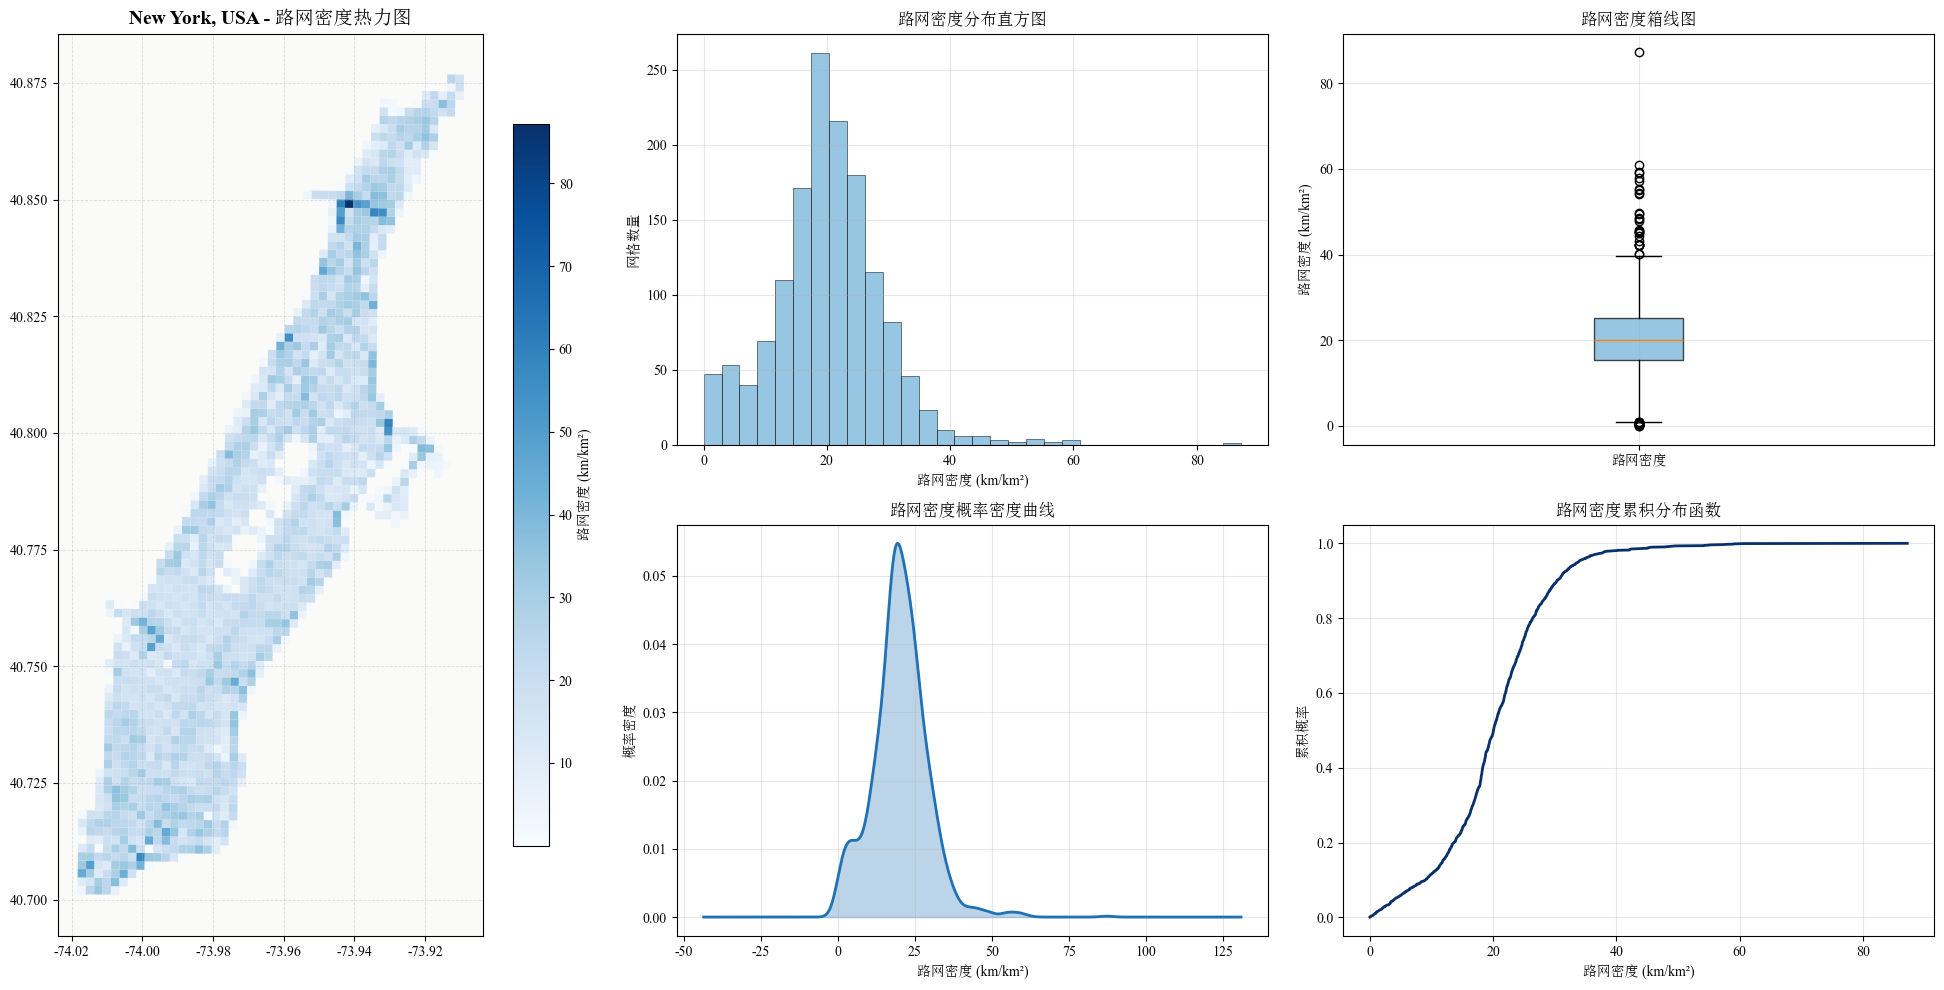


New York, USA - 路网密度详细统计分析
总网格数量: 4410
有效网格数量 (密度>0): 1450
空网格数量: 2960
空网格比例: 67.1%

路网密度统计 (排除空网格):
  最小值: 0.02 km/km²
  最大值: 87.21 km/km²
  平均值: 20.24 km/km²
  中位数: 20.07 km/km²
  标准差: 8.97 km/km²
  偏度: 0.660
  峰度: 3.511

分位数统计:
  10%分位数: 9.07 km/km²
  25%分位数: 15.49 km/km²
  50%分位数: 20.07 km/km²
  75%分位数: 25.14 km/km²
  90%分位数: 30.38 km/km²

密度等级分布:
  极低(0-5): 85个网格 (5.9%)
  低(5-10): 81个网格 (5.6%)
  中(10-15): 175个网格 (12.1%)
  高(15-20): 376个网格 (25.9%)
  极高(>20): 733个网格 (50.6%)


In [18]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

def visualize_road_density(gdf_path, place_name):
    """
    可视化路网密度分析结果
    """
    # 读取数据
    grid_gdf = gpd.read_file(gdf_path)
    
    # 过滤掉密度为0的网格用于统计分析
    non_zero_density = grid_gdf[grid_gdf['density'] > 0]['density']

    # 创建图形
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(2, 3, figure=fig)
    
    # 左侧：热力图
    ax1 = fig.add_subplot(gs[:, 0])  # 占据左侧全部
    
    # 创建自定义颜色映射
    colors = ['#f7fbff', '#6baed6', '#2171b5', '#08306b']
    cmap = plt.cm.get_cmap('Blues')
    
    # 绘制热力图
    none_zero=grid_gdf[grid_gdf['density'] > 0]
    none_zero.to_crs("EPSG:4326", inplace=True)
    none_zero.plot(column='density', cmap=cmap, ax=ax1, legend=True,
                 legend_kwds={'label': '路网密度 (km/km²)', 'shrink': 0.8})
    
    ax1.set_title(f'{place_name} - 路网密度热力图', fontsize=14, fontweight='bold')
    # 添加经纬度网格
    ax1.grid(True, alpha=0.4, linestyle='--', color='#A0AEC0', linewidth=0.6)
    ax1.get_xaxis().set_visible(True)
    ax1.get_yaxis().set_visible(True)
    ax1.set_axis_on()
    ax1.set_facecolor('#FAFAF8')
    # 右侧：统计图表
    # 直方图
    ax2 = fig.add_subplot(gs[0, 1])
    n, bins, patches = ax2.hist(non_zero_density, bins=30, alpha=0.7, color='#6baed6', 
                               edgecolor='black', linewidth=0.5)
    ax2.set_title('路网密度分布直方图', fontsize=12, fontweight='bold')
    ax2.set_xlabel('路网密度 (km/km²)')
    ax2.set_ylabel('网格数量')
    ax2.grid(True, alpha=0.3)
    
    # 箱线图
    ax3 = fig.add_subplot(gs[0, 2])
    box_data = [non_zero_density.values]
    box_plot = ax3.boxplot(box_data, patch_artist=True, labels=['路网密度'])
    # 设置箱线图颜色
    for patch in box_plot['boxes']:
        patch.set_facecolor('#6baed6')
        patch.set_alpha(0.7)
    ax3.set_title('路网密度箱线图', fontsize=12, fontweight='bold')
    ax3.set_ylabel('路网密度 (km/km²)')
    ax3.grid(True, alpha=0.3)
    
    # 密度曲线图
    ax4 = fig.add_subplot(gs[1, 1])
    density_curve = non_zero_density.plot.kde(ax=ax4, color='#2171b5', linewidth=2)
    ax4.set_title('路网密度概率密度曲线', fontsize=12, fontweight='bold')
    ax4.set_xlabel('路网密度 (km/km²)')
    ax4.set_ylabel('概率密度')
    ax4.grid(True, alpha=0.3)
    # 填充曲线下方区域
    x = density_curve.lines[0].get_xdata()
    y = density_curve.lines[0].get_ydata()
    ax4.fill_between(x, y, alpha=0.3, color='#2171b5')
    
    # 累积分布图
    ax5 = fig.add_subplot(gs[1, 2])
    sorted_data = np.sort(non_zero_density)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    ax5.plot(sorted_data, cdf, linewidth=2, color='#08306b')
    ax5.set_title('路网密度累积分布函数', fontsize=12, fontweight='bold')
    ax5.set_xlabel('路网密度 (km/km²)')
    ax5.set_ylabel('累积概率')
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # 保存图片
    output_filename = f"road_density_visualization_{place_name.replace(' ', '_')}.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"可视化结果已保存为: {output_filename}")
    
    plt.show()
    
    # 打印详细统计信息
    print(f"\n{place_name} - 路网密度详细统计分析")
    print("=" * 50)
    print(f"总网格数量: {len(grid_gdf)}")
    print(f"有效网格数量 (密度>0): {len(non_zero_density)}")
    print(f"空网格数量: {len(grid_gdf) - len(non_zero_density)}")
    print(f"空网格比例: {(len(grid_gdf) - len(non_zero_density)) / len(grid_gdf) * 100:.1f}%")
    print("\n路网密度统计 (排除空网格):")
    print(f"  最小值: {non_zero_density.min():.2f} km/km²")
    print(f"  最大值: {non_zero_density.max():.2f} km/km²")
    print(f"  平均值: {non_zero_density.mean():.2f} km/km²")
    print(f"  中位数: {non_zero_density.median():.2f} km/km²")
    print(f"  标准差: {non_zero_density.std():.2f} km/km²")
    print(f"  偏度: {non_zero_density.skew():.3f}")
    print(f"  峰度: {non_zero_density.kurtosis():.3f}")
    
    # 分位数统计
    print("\n分位数统计:")
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    for q in quantiles:
        value = non_zero_density.quantile(q)
        print(f"  {int(q*100)}%分位数: {value:.2f} km/km²")
    
    # 密度等级统计
    print("\n密度等级分布:")
    density_bins = [0, 5, 10, 15, 20, float('inf')]
    density_labels = ['极低(0-5)', '低(5-10)', '中(10-15)', '高(15-20)', '极高(>20)']
    
    for i in range(len(density_bins)-1):
        if i == len(density_bins)-2:  # 最后一个区间
            count = len(non_zero_density[non_zero_density >= density_bins[i]])
        else:
            count = len(non_zero_density[(non_zero_density >= density_bins[i]) & 
                                       (non_zero_density < density_bins[i+1])])
        percentage = count / len(non_zero_density) * 100
        print(f"  {density_labels[i]}: {count}个网格 ({percentage:.1f}%)")

# 使用示例
visualize_road_density(r"D:\必须用电脑解决的作业\地理大数据分析\实习三\实习三代码\new_york_road_density.gpkg", "New York, USA")



### 道路连通性分析
计算每个道路的节点的度数与总结点的关系

可视化结果已保存为: connectivity_degree_visualization_New_York,_USA.png


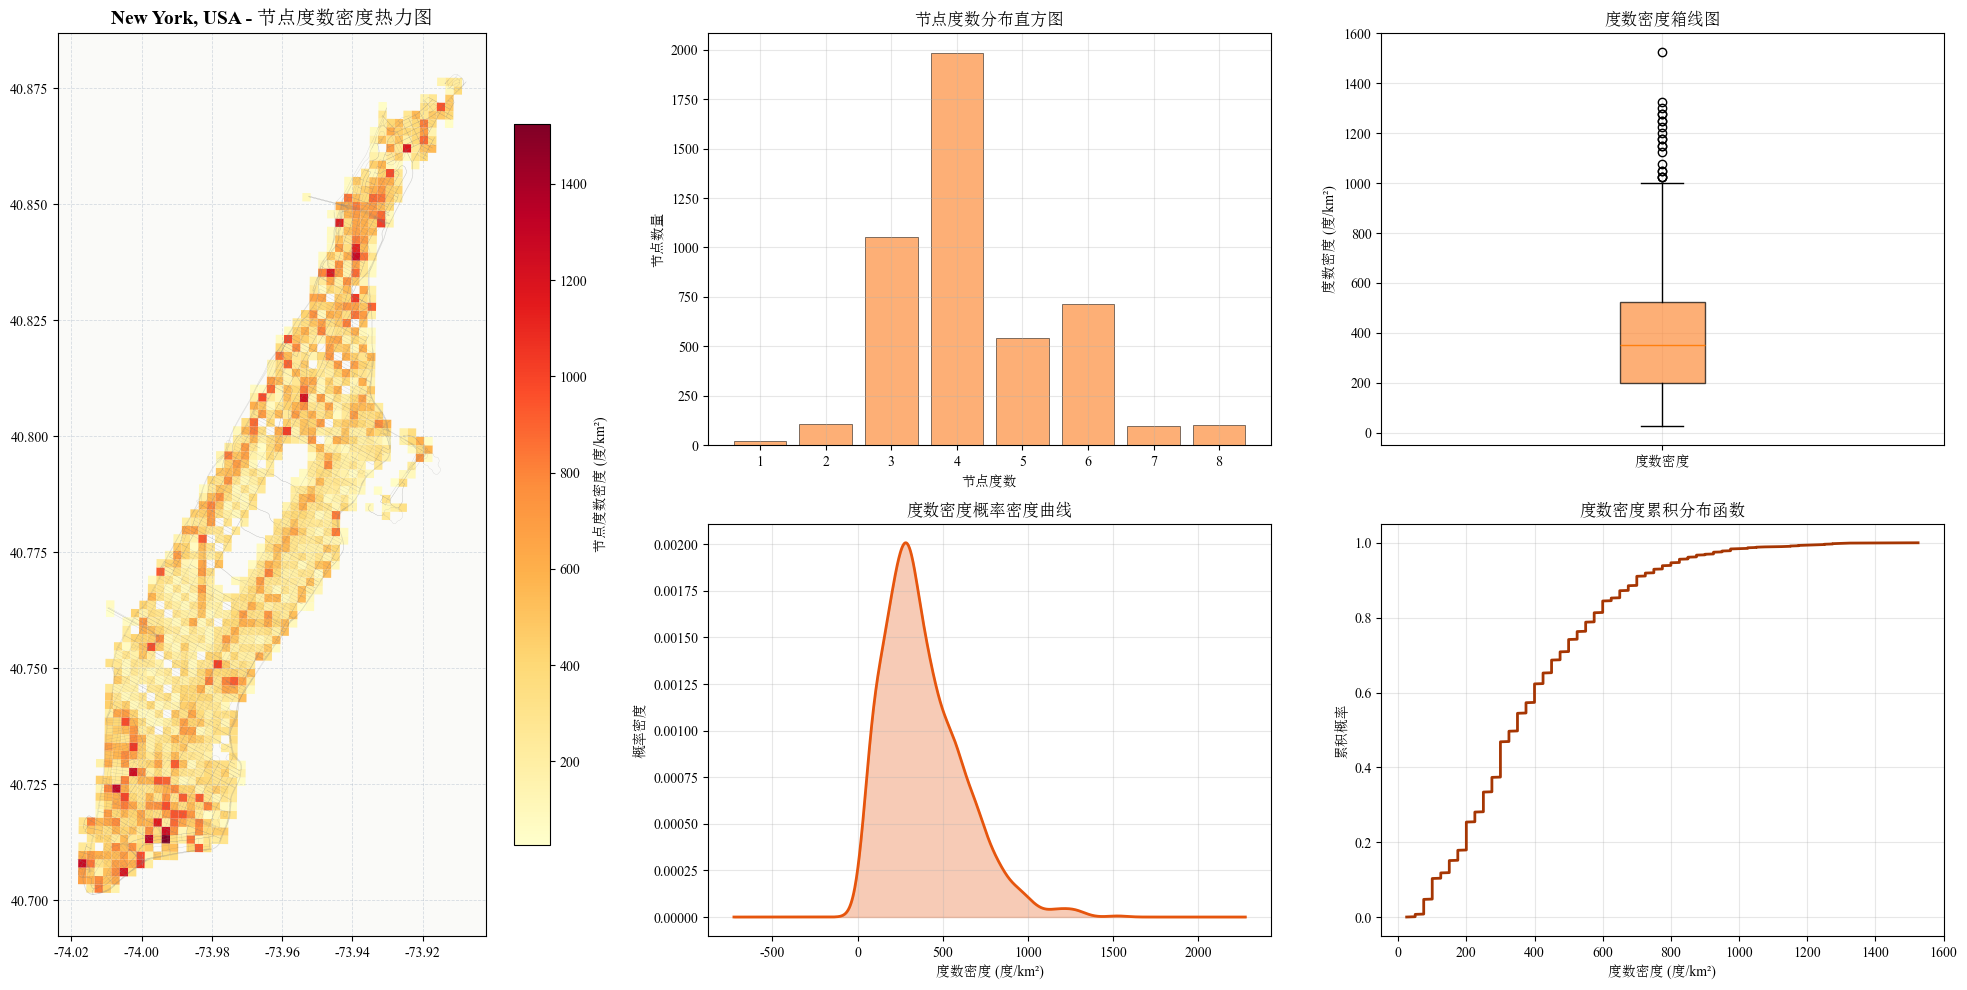


New York, USA - 节点度数连通性详细统计分析
节点总数: 4619
边总数: 9900
总网格数量: 4410
有效网格数量 (度数密度>0): 1274
空网格数量: 3136
空网格比例: 71.1%

节点度数统计:
  最小值: 1
  最大值: 8
  平均值: 4.29
  中位数: 4.0
  标准差: 1.24

度数密度统计 (排除空网格):
  最小值: 25.0 度/km²
  最大值: 1525.0 度/km²
  平均值: 387.8 度/km²
  中位数: 350.0 度/km²
  标准差: 231.9 度/km²
  偏度: 1.036
  峰度: 1.310

度数密度分位数统计:
  10%分位数: 100.0 度/km²
  25%分位数: 200.0 度/km²
  50%分位数: 350.0 度/km²
  75%分位数: 525.0 度/km²
  90%分位数: 700.0 度/km²

度数密度等级分布:
  极低(0-1k): 1253个网格 (98.4%)
  低(1k-2k): 21个网格 (1.6%)
  中(2k-5k): 0个网格 (0.0%)
  高(5k-10k): 0个网格 (0.0%)
  极高(>10k): 0个网格 (0.0%)

节点度数类型统计:
  端点 (度=1): 21个 (0.5%)
  中间点 (度=2): 108个 (2.3%)
  交叉口 (度≥3): 4490个 (97.2%)
格网数据已保存为: New_York_USA_connectivity_grid.geojson
格网数据已保存为: New_York_USA_connectivity_grid.gpkg


In [17]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
from shapely.geometry import Polygon

def analyze_connectivity_degree(G, place_name, grid_size=200):
    """
    基于节点度数分析路网连通性
    """
    # 首先投影到UTM坐标系
    G_proj = ox.project_graph(G)
    nodes, edges = ox.graph_to_gdfs(G_proj)
    
    # 计算每个节点的度数
    node_degrees = dict(G_proj.degree())
    nodes['degree'] = nodes.index.map(node_degrees)
    
    # 计算总度数（每个网格内所有节点度数的总和）
    bounds = nodes.total_bounds
    x_coords = np.arange(bounds[0], bounds[2], grid_size)
    y_coords = np.arange(bounds[1], bounds[3], grid_size)
    
    total_degrees = []
    avg_degrees = []
    grid_polygons = []
    
    for i in range(len(x_coords)-1):
        for j in range(len(y_coords)-1):
            poly = Polygon([
                (x_coords[i], y_coords[j]),
                (x_coords[i+1], y_coords[j]),
                (x_coords[i+1], y_coords[j+1]),
                (x_coords[i], y_coords[j+1])
            ])
            
            # 计算网格内的节点
            nodes_in_grid = nodes[nodes.within(poly)]
            
            if len(nodes_in_grid) > 0:
                # 总度数
                total_degree = nodes_in_grid['degree'].sum()
                # 平均度数（每平方公里的总度数）
                grid_area = grid_size**2 / 1000000  # 平方公里
                avg_degree_density = total_degree / grid_area
            else:
                total_degree = 0
                avg_degree_density = 0
            
            total_degrees.append(total_degree)
            avg_degrees.append(avg_degree_density)
            grid_polygons.append(poly)
    
    # 创建网格GeoDataFrame
    grid_gdf = gpd.GeoDataFrame({
        'total_degree': total_degrees,
        'avg_degree_density': avg_degrees
    }, geometry=grid_polygons, crs=nodes.crs)
    
    # 转换回WGS84用于可视化
    grid_gdf_wgs84 = grid_gdf.to_crs("EPSG:4326")
    nodes_wgs84 = nodes.to_crs("EPSG:4326")
    edges_wgs84 = edges.to_crs("EPSG:4326")
    
    # 过滤掉密度为0的网格用于统计分析
    non_zero_density = grid_gdf[grid_gdf['avg_degree_density'] > 0]['avg_degree_density']
    
    # 创建图形
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(2, 3, figure=fig)
    
    # 左侧：度数密度热力图
    ax1 = fig.add_subplot(gs[:, 0])  # 占据左侧全部
    
    # 使用暖色系色带
    cmap = plt.cm.get_cmap('YlOrRd')
    
    # 绘制热力图（只显示非零区域）
    non_zero_grid = grid_gdf_wgs84[grid_gdf_wgs84['avg_degree_density'] > 0]
    non_zero_grid.plot(column='avg_degree_density', cmap=cmap, ax=ax1, legend=True,
                      legend_kwds={'label': '节点度数密度 (度/km²)', 'shrink': 0.8})
    
    # 添加路网底图
    edges_wgs84.plot(ax=ax1, color='gray', linewidth=0.2, alpha=0.4)
    
    ax1.set_title(f'{place_name} - 节点度数密度热力图', fontsize=14, fontweight='bold')
    # 添加经纬度网格
    ax1.grid(True, alpha=0.4, linestyle='--', color='#A0AEC0', linewidth=0.6)
    ax1.get_xaxis().set_visible(True)
    ax1.get_yaxis().set_visible(True)
    ax1.set_axis_on()
    ax1.set_facecolor('#FAFAF8')
    
    # 右侧：统计图表
    
    # 节点度数分布直方图
    ax2 = fig.add_subplot(gs[0, 1])
    degree_values = list(node_degrees.values())
    degree_counts = pd.Series(degree_values).value_counts().sort_index()
    ax2.bar(degree_counts.index, degree_counts.values, color='#fd8d3c', alpha=0.7, 
            edgecolor='black', linewidth=0.5)
    ax2.set_title('节点度数分布直方图', fontsize=12, fontweight='bold')
    ax2.set_xlabel('节点度数')
    ax2.set_ylabel('节点数量')
    ax2.grid(True, alpha=0.3)
    
    # 度数密度箱线图
    ax3 = fig.add_subplot(gs[0, 2])
    box_data = [non_zero_density.values]
    box_plot = ax3.boxplot(box_data, patch_artist=True, labels=['度数密度'])
    # 设置箱线图颜色（暖色系）
    for patch in box_plot['boxes']:
        patch.set_facecolor('#fd8d3c')
        patch.set_alpha(0.7)
    ax3.set_title('度数密度箱线图', fontsize=12, fontweight='bold')
    ax3.set_ylabel('度数密度 (度/km²)')
    ax3.grid(True, alpha=0.3)
    
    # 度数密度概率密度曲线
    ax4 = fig.add_subplot(gs[1, 1])
    density_curve = non_zero_density.plot.kde(ax=ax4, color='#e6550d', linewidth=2)
    ax4.set_title('度数密度概率密度曲线', fontsize=12, fontweight='bold')
    ax4.set_xlabel('度数密度 (度/km²)')
    ax4.set_ylabel('概率密度')
    ax4.grid(True, alpha=0.3)
    # 填充曲线下方区域
    x = density_curve.lines[0].get_xdata()
    y = density_curve.lines[0].get_ydata()
    ax4.fill_between(x, y, alpha=0.3, color='#e6550d')
    
    # 度数密度累积分布图
    ax5 = fig.add_subplot(gs[1, 2])
    sorted_data = np.sort(non_zero_density)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    ax5.plot(sorted_data, cdf, linewidth=2, color='#a63603')
    ax5.set_title('度数密度累积分布函数', fontsize=12, fontweight='bold')
    ax5.set_xlabel('度数密度 (度/km²)')
    ax5.set_ylabel('累积概率')
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # 保存图片
    output_filename = f"connectivity_degree_visualization_{place_name.replace(' ', '_')}.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"可视化结果已保存为: {output_filename}")
    
    plt.show()
    
    # 打印详细统计信息
    print(f"\n{place_name} - 节点度数连通性详细统计分析")
    print("=" * 60)
    print(f"节点总数: {len(nodes)}")
    print(f"边总数: {len(edges)}")
    print(f"总网格数量: {len(grid_gdf)}")
    print(f"有效网格数量 (度数密度>0): {len(non_zero_density)}")
    print(f"空网格数量: {len(grid_gdf) - len(non_zero_density)}")
    print(f"空网格比例: {(len(grid_gdf) - len(non_zero_density)) / len(grid_gdf) * 100:.1f}%")
    
    print("\n节点度数统计:")
    degree_series = pd.Series(degree_values)
    print(f"  最小值: {degree_series.min()}")
    print(f"  最大值: {degree_series.max()}")
    print(f"  平均值: {degree_series.mean():.2f}")
    print(f"  中位数: {degree_series.median()}")
    print(f"  标准差: {degree_series.std():.2f}")
    
    print("\n度数密度统计 (排除空网格):")
    print(f"  最小值: {non_zero_density.min():.1f} 度/km²")
    print(f"  最大值: {non_zero_density.max():.1f} 度/km²")
    print(f"  平均值: {non_zero_density.mean():.1f} 度/km²")
    print(f"  中位数: {non_zero_density.median():.1f} 度/km²")
    print(f"  标准差: {non_zero_density.std():.1f} 度/km²")
    print(f"  偏度: {non_zero_density.skew():.3f}")
    print(f"  峰度: {non_zero_density.kurtosis():.3f}")
    
    # 分位数统计
    print("\n度数密度分位数统计:")
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    for q in quantiles:
        value = non_zero_density.quantile(q)
        print(f"  {int(q*100)}%分位数: {value:.1f} 度/km²")
    
    # 度数密度等级统计
    print("\n度数密度等级分布:")
    density_bins = [0, 1000, 2000, 5000, 10000, float('inf')]
    density_labels = ['极低(0-1k)', '低(1k-2k)', '中(2k-5k)', '高(5k-10k)', '极高(>10k)']
    
    for i in range(len(density_bins)-1):
        if i == len(density_bins)-2:  # 最后一个区间
            count = len(non_zero_density[non_zero_density >= density_bins[i]])
        else:
            count = len(non_zero_density[(non_zero_density >= density_bins[i]) & 
                                       (non_zero_density < density_bins[i+1])])
        percentage = count / len(non_zero_density) * 100
        print(f"  {density_labels[i]}: {count}个网格 ({percentage:.1f}%)")
    
    # 节点度数类型统计
    print("\n节点度数类型统计:")
    degree_1 = len(nodes[nodes['degree'] == 1])
    degree_2 = len(nodes[nodes['degree'] == 2])
    degree_3_plus = len(nodes[nodes['degree'] >= 3])
    
    print(f"  端点 (度=1): {degree_1}个 ({degree_1/len(nodes)*100:.1f}%)")
    print(f"  中间点 (度=2): {degree_2}个 ({degree_2/len(nodes)*100:.1f}%)")
    print(f"  交叉口 (度≥3): {degree_3_plus}个 ({degree_3_plus/len(nodes)*100:.1f}%)")
    
    #储存格网
    base_name = place_name.replace(' ', '_').replace(',', '')
    
    # 保存为GeoJSON
    non_zero_grid_wgs84=non_zero_grid.to_crs("EPSG:4326")
    geojson_file = f"{base_name}_connectivity_grid.geojson"
    non_zero_grid_wgs84.to_file(geojson_file, driver='GeoJSON')
    print(f"格网数据已保存为: {geojson_file}")
    
    # 保存为GPKG
    gpkg_file = f"{base_name}_connectivity_grid.gpkg"
    non_zero_grid_wgs84.to_file(gpkg_file, driver='GPKG')
    print(f"格网数据已保存为: {gpkg_file}")
    
    return grid_gdf_wgs84, nodes

# 使用示例

connectivity_grid, nodes_data = analyze_connectivity_degree(G, "New York, USA")
